In [1]:
# =============================
# IMPORT LIBRARIES
# =============================
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torchvision.models as models

# =============================
# DEVICE
# =============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [2]:
# =============================
# DATASET CLASS
# =============================
class WeatherDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        self.class_names = ["Cloudy", "Rain", "Shine", "Sunrise"]
        self.samples = []

        for label, class_name in enumerate(self.class_names):
            class_path = os.path.join(root_dir, class_name)
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                self.samples.append((img_path, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label

In [3]:
# =============================
# TRANSFORMS (IMPORTANT)
# =============================
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])


In [4]:
import zipfile
import os

zip_path = "archive.zip"  
extract_path = "weatherdataset" 

os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Done! Files extracted to:", extract_path)


Done! Files extracted to: weatherdataset


In [5]:
# =============================
# LOAD DATA
# =============================
dataset = WeatherDataset(
    root_dir="weatherdataset/Multi-class Weather Dataset", 
    transform=transform
)



train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset,[train_size,test_size])

train_loader = DataLoader(train_dataset,batch_size=32,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=32,shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4285715].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


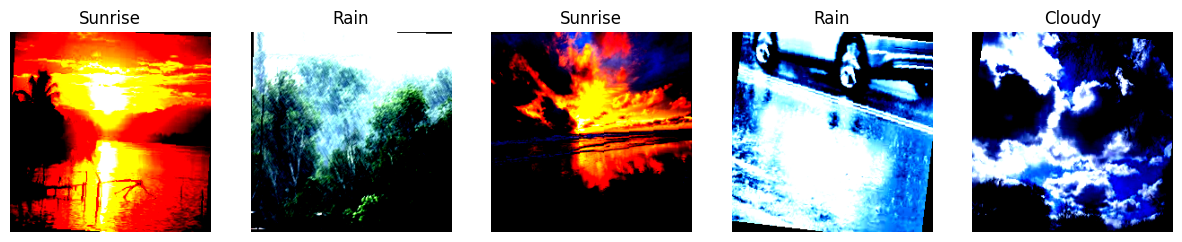

In [6]:
# =============================
# SHOW RANDOM SAMPLES
# =============================
def show_random_samples(dataset, class_names, num_samples=5):
    indices = random.sample(range(len(dataset)), num_samples)
    plt.figure(figsize=(15,3))

    for i, idx in enumerate(indices):
        image, label = dataset[idx]
        image = image.permute(1,2,0).numpy()

        plt.subplot(1,num_samples,i+1)
        plt.imshow(image)
        plt.title(class_names[label])
        plt.axis("off")

    plt.show()

show_random_samples(dataset,
                    ["Cloudy","Rain","Shine","Sunrise"])

In [7]:
# =============================
# PRETRAINED MODEL (RESNET18)
# =============================
from torchvision.models import resnet18, ResNet18_Weights

model = resnet18(weights=ResNet18_Weights.DEFAULT)


# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Replace final layer
num_features = model.fc.in_features
model.fc = nn.Linear(num_features,4)

model = model.to(device)

In [8]:
# =============================
# LOSS & OPTIMIZER (PHASE 1)
# =============================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=1e-3)

In [9]:
# =============================
# TRAIN FUNCTION
# =============================
def trainModel(model, dataloader, criterion, optimizer, epochs=5):
    model.train()

    for epoch in range(epochs):
        running_loss = 0

        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs} | Loss: {running_loss/len(dataloader):.4f}")

In [10]:
# =============================
# TEST FUNCTION
# =============================
def testModel(model, dataloader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item()

            _, predicted = torch.max(outputs,1)
            correct += (predicted==labels).sum().item()
            total += labels.size(0)

    print(f"Validation Loss: {test_loss/len(dataloader):.4f}")
    print(f"Validation Accuracy: {100*correct/total:.2f}%")


In [11]:
# =============================
# PHASE 1 TRAINING
# =============================
print("Feature Extraction Training...")
trainModel(model, train_loader, criterion, optimizer, epochs=5)
testModel(model, test_loader, criterion)

Feature Extraction Training...
Epoch 1/5 | Loss: 1.1117
Epoch 2/5 | Loss: 0.6254
Epoch 3/5 | Loss: 0.4513
Epoch 4/5 | Loss: 0.3807
Epoch 5/5 | Loss: 0.3094
Validation Loss: 0.2683
Validation Accuracy: 93.33%


In [ ]:
# =============================
# FINE-TUNING PHASE
# =============================
print("Fine-Tuning...")

# Unfreeze last block only
for name, param in model.named_parameters():
    if "layer4" in name:
        param.requires_grad = True

optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-5
)

trainModel(model, train_loader, criterion, optimizer, epochs=5)
testModel(model, test_loader, criterion)

Fine-Tuning...


In [ ]:
# =============================
# SAVE MODEL
# =============================
torch.save(model.state_dict(),"weather_resnet18.pth")

In [ ]:
import tkinter as tk
from tkinter import filedialog
from PIL import Image, ImageTk
import torch
from torchvision import transforms
from torchvision.models import resnet18, ResNet18_Weights
import torch.nn as nn

# ============================
# Load Pretrained Model
# ============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model
model = resnet18(weights=ResNet18_Weights.DEFAULT)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 4)
model.load_state_dict(torch.load("weather_resnet18.pth", map_location=device))
model = model.to(device)
model.eval()

class_names = ["Cloudy", "Rain", "Shine", "Sunrise"]

# ============================
# Transform for input images
# ============================
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])

# ============================
# GUI Functions
# ============================
def open_file():
    file_path = filedialog.askopenfilename()
    if file_path:
        load_image(file_path)
        predict_image(file_path)

def load_image(file_path):
    img = Image.open(file_path)
    img = img.resize((250,250))
    img_tk = ImageTk.PhotoImage(img)
    image_label.config(image=img_tk)
    image_label.image = img_tk

def predict_image(file_path):
    img = Image.open(file_path).convert("RGB")
    img_t = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(img_t)
        _, pred = torch.max(output,1)
        result_label.config(text=f"Prediction: {class_names[pred.item()]}")

# ============================
# GUI Layout
# ============================
root = tk.Tk()
root.title("Weather Classification GUI")
root.geometry("300x400")

open_button = tk.Button(root, text="Choose Image", command=open_file)
open_button.pack(pady=10)

image_label = tk.Label(root)
image_label.pack()

result_label = tk.Label(root, text="Prediction: ", font=("Arial", 14))
result_label.pack(pady=20)

root.mainloop()
